<a href="https://colab.research.google.com/github/Divyanshu-Singh-Chauhan/Image-Forgery-Detection/blob/master/PCA_based_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import math


#**STEP 1 - READING AND PREPROCESSING**

In [ ]:
##Reading the image in Gray Scale
img = cv2.imread('/content/Aadhar_updated.png',0)
img_resize = cv2.resize(img,(440,440))
print(img.shape)
print(img_resize.shape)

(440, 644)
(440, 440)


In [ ]:
plt.imshow(img_resize,cmap = 'gray')

#**STEP 2 - INITIALIZATING PARAMS**

In [ ]:
 ##DEFINING THE PARAMETERS
(winW,winH) = (8,8)
stepsize = 1
#n_root = img.shape[0]
#e = 0.01              #fraction of the ignored variance along the principal axes
q = 256               #number of quantization bins
nn = 20             #number of neighboring rows to search in the lexicographically sorted matrix
nf = 400        #minimum frequency threshold
nd = 30              #minimum offset threshold
n_components = 1
#nt is chosen s.t n_components = 16

#**STEP 3 - PCA REDUCTION ON IMAGE BLOCKS(SLIDING WINDOW)**

In [ ]:
##DEFINING THE SLIDING WINDOW
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [ ]:
###APPLYING PCA
def pca_(image,n_components):

  #scaler = StandardScaler()
  #fit and transform to mean = 0
  #scaler.fit(image)
  #image = scaler.transform(image)
  

  #apply PCA with n_components = n_components
  pca = PCA(n_components=n_components)
  pca.fit(image)

  #pca.n_components
  #print(pca._n_components)

  #apply pca transformation
  train_img = pca.transform(image)
  
  #prints
  #print(np.mean(image))
  #print(np.mean(train_img))
  #prints(train_img.shape)
  #print(pca.explained_variance_ratio_)

  return train_img

#**STEP 4 - BUILDING A FLATTENED MATRIX OF REDUCED FEATURES OF (NB * B)** 

In [ ]:
###ARRAY IS GENERATED WITH ROWS CORRESPONDING TO IMAGE OF THE EACH BLOCK

coord_arr = []
def arr_generate(image):

  count = 1
  cnt = 0
  for (x, y, window) in sliding_window(image, stepSize=stepsize, windowSize=(winW, winH)):
    if window.shape[0]!=winH or window.shape[1]!= winW:
      continue 
    if count == 1:
      arr_flat = []
      count +=1
    coord_arr.append((x,y)) #### storing the top-left coordinates of each block
    window = window.flatten()
    window = window.tolist()
    arr_flat.append(window)   

  return arr_flat    

In [ ]:
arr = arr_generate(img_resize)
arr= np.array(arr,float)
arr = arr/q     ##using quantization bin i.e q = 255.0  

In [ ]:
arr.shape

(187489, 64)

In [ ]:
arr_red = pca_(arr,64)

In [ ]:
arr_red[0:8]

**STEP 5 - SORTING THE MATRIX LEXOGRAPHICALLY AND RETRIEVING THE ORDERED COORDINATES OF THE BLOCK**

In [ ]:
###Lexicographical Sorting 

def lexsort(x):
  return x[np.lexsort(np.rot90(x))]  

In [ ]:
##Sorted array created above through reduced features
arr_sorted = lexsort(arr_red)
print(arr_sorted[50:150])
##We have the sorted array

[[-1.54009377e+00  1.02582823e-01  4.30372129e-01 ...  4.22583353e-04
  -3.50769052e-04  1.56089762e-04]
 [-1.53998341e+00  1.14669759e-01  4.26288775e-01 ...  7.34712694e-04
  -1.10469491e-03 -7.02102113e-04]
 [-1.53963950e+00  9.76935798e-02  4.34717985e-01 ... -3.64978282e-04
   4.05549901e-04 -3.13830643e-04]
 ...
 [-1.44185282e+00  8.56799224e-02  4.40358074e-01 ...  9.11826893e-05
   4.78662290e-04  5.06994614e-03]
 [-1.43810942e+00  1.20139016e-01  4.49254275e-01 ... -8.90521967e-04
  -1.08594361e-04 -1.15691510e-03]
 [-1.43762766e+00 -9.51821659e-03  6.43336934e-03 ...  2.67982961e-04
  -1.04603910e-04 -1.87947394e-04]]


In [ ]:
arr_sorted_index = np.lexsort(np.rot90(arr_red))
print(arr_sorted_index)

[  297   298   299 ... 83063 83064 83065]


In [ ]:
###Now we have the index and the coordinates of the blocks and we need to reorder the coordinates list
#coord_arr  --- list of the cooordinates
#arr_sorted_index --- list of the indices of the sorted list

In [ ]:
arr_sorted_index = arr_sorted_index.tolist()

In [ ]:
### Finding the reordered list
#coord_arr_sorted = [x for y, x in sorted(zip(arr_sorted_index,coord_arr))]
coord_arr_sorted = []
for i in arr_sorted_index:
  coord_arr_sorted.append(coord_arr[i])
##Now we have the list of ordered coordinates of the image blocks

#**STEP 6 - GENERATING ALL POSSIBLE PAIRS WITH A GIVEN THRESHOLD**

In [ ]:
#### Calculating the pairs given in eqn 6
nb = arr_sorted.shape[0]
pairs_list = []
for i in range(int(nb)):
  for j in range(i+1,i+nn) :
    if j < nb:
      pairs_list.append([coord_arr_sorted[i],coord_arr_sorted[j]])

In [ ]:

print(len(pairs_list))
print(pairs_list[1])

3562101
[(297, 0), (299, 0)]


#**STEP 7 - COMPUTING THE OFFSETS OF THE PREVIOUS GENERATED PAIRS**

In [ ]:
#### COMPUTING LIST OF OFFSETS

offset_list = []
for i in range(len(pairs_list)):
  if (pairs_list[i][0][0]-pairs_list[i][1][0]) == 0:
    offset_list.append([0,abs(pairs_list[i][0][1]-pairs_list[i][1][1])])
  else :
    offset_list.append([abs(pairs_list[i][0][0]-pairs_list[i][1][0]),(pairs_list[i][0][1]-pairs_list[i][1][1])])

len(offset_list)

3562101

In [ ]:
print(offset_list[1])

[2, 0]


#**STEP 8 - DISCARDING PAIRS WITH OFFSET FREQUENCY LESS THAN A THRESHOLD**

In [ ]:
### DISCARDING PAIRS WITH VALUES LESS THAN OFFSET FREQUENCY 
mp = dict()
def offset_freq(list1):
  lista = list1.copy()
  for i in range(len(lista)):
    if tuple(lista[i]) in mp.keys():
      mp[tuple(lista[i])] +=1
    else:
      mp[tuple(lista[i])] = 1

  for j in range(len(lista)):
    if mp[tuple(lista[j])]< nf:
      lista[j] = 0            
  return lista      

#**STEP 9 - DISCARDING PAIRS WITH OFFSET MAGN. LESS THAN THRESHOLD**

In [ ]:
#### DISCARD FUNCTION FOR OFFSET MAGNITUDE

def offset_magnitude(lista):
  
  for i in range(len(lista)):
    if lista[i]!=0:
      magnitude = math.sqrt(lista[i][0]**2+lista[i][1]**2)
      if magnitude > nd:
        lista[i] = None
      else :
        lista[i] = 0      
      
  return lista

# **STEP 10 - COMPUTING THE REMAINING COORDINATES OF THE BLOCKS**

In [ ]:
lista = offset_freq(offset_list)

In [ ]:
updated_offset_list = offset_magnitude(lista)


In [ ]:
mp

In [ ]:
### MAPPING OF NONE ELEMENTS TO THE COORDINATES

## getting the indices of the None elements
res = [i for i, val in enumerate(updated_offset_list) if val == None]

### RETRIEVE THE DUPLICATED COORDINATE PAIRS 
updated_pairs_list = []
for i in res:
  updated_pairs_list.append(pairs_list[i]) 

In [ ]:
len(updated_pairs_list)

638

In [ ]:
### Flattening the Updated_pairs_list
flat_list = []
for sublist in updated_pairs_list:
    for item in sublist:
        flat_list.append(item)

In [ ]:
len(flat_list)

1276

In [ ]:
### FINAL LIST CONSISTING OF TUPLES OF COORDINATES WITH DUPLICATIONS WHICH WILL BE DIRECTLY USED TO GENERATE THE GRAYSCALE IMAGE
unique = np.unique(flat_list, axis=0)

In [ ]:
len(unique)

1263

In [ ]:
unique[1:11]

array([[ 22, 217],
       [ 22, 218],
       [ 22, 229],
       [ 22, 230],
       [ 22, 231],
       [ 22, 232],
       [ 22, 233],
       [ 22, 307],
       [ 22, 308],
       [ 22, 309]])

#**STEP 11 - GENERATING THE DUPLICATE IMAGE WITH THE TAMPERED AREA**

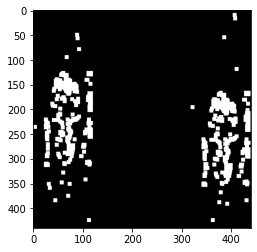

In [ ]:
### creating an array of the same size as that of resized input image
duplication = np.zeros((img_resize.shape[0],img_resize.shape[1]))

### Giving values to the duplicated regions as 255
for coord in unique:
  duplication[coord[0]:coord[0]+winW,coord[1]:coord[1]+winH] = 255  

duplication_rotate = cv2.rotate(duplication,cv2.ROTATE_90_COUNTERCLOCKWISE)
dup_aligned = cv2.flip(duplication_rotate,0)
### Showing the image
plt.gray
plt.imshow(dup_aligned, cmap = 'gray', vmin = 0, vmax = 255)  

In [ ]:
plt.imshow(img_resize,cmap = 'gray')